In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
df = pd.read_csv("DataSet/HAM.csv")
df['image_id'] = df['image_id'].apply(lambda x: x + ".jpg")
class_counts = df['dx'].value_counts()

# Print the counts for each class
print(class_counts)

dx
bkl      7000
nv       7000
df       7000
mel      7000
vasc     7000
bcc      7000
akiec    7000
Name: count, dtype: int64


In [17]:
# Define image dimensions and batch size
img_size = (200, 200)
batch_size = 16

# Create data generators for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [18]:
train_df, test_valid_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)
train_df['image_id'] = 'DataSet/Combined/' + train_df['image_id']
valid_df['image_id'] = 'DataSet/Combined/' + valid_df['image_id']
test_df['image_id'] = 'DataSet/Combined/' + test_df['image_id']

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 34300 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.


In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))


x = base_model.output
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation=swish)(x)
x = Dropout(0.5)(x)
x = Dense(256, activation=swish)(x)
x = Dropout(0.5)(x)

predictions = Dense(7, activation='softmax')(x)  # Replace NUM_CLASSES with the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

In [21]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=150,  # You can adjust the number of epochs
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/150
2144/2144 [==============================] - 456s 208ms/step - loss: 1.7594 - accuracy: 0.2777 - val_loss: 1.7186 - val_accuracy: 0.3118
Epoch 2/150
2144/2144 [==============================] - 409s 191ms/step - loss: 1.6354 - accuracy: 0.3410 - val_loss: 198.3539 - val_accuracy: 0.2707
Epoch 3/150
2144/2144 [==============================] - 408s 190ms/step - loss: 1.5836 - accuracy: 0.3665 - val_loss: 1.5335 - val_accuracy: 0.3741
Epoch 4/150
2144/2144 [==============================] - 414s 193ms/step - loss: 1.4924 - accuracy: 0.4013 - val_loss: 1.3586 - val_accuracy: 0.4393
Epoch 5/150
2144/2144 [==============================] - 415s 193ms/step - loss: 1.5070 - accuracy: 0.3972 - val_loss: 1.4606 - val_accuracy: 0.4291
Epoch 6/150
2144/2144 [==============================] - 415s 194ms/step - loss: 1.4598 - accuracy: 0.4122 - val_loss: 1.3538 - val_accuracy: 0.4578
Epoch 7/150
2144/2144 [==============================] - 410s 191ms/step - loss: 1.4371 - accuracy: 0.41

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

460/460 [==============================] - 72s 156ms/step - loss: 0.2770 - accuracy: 0.9341
Test accuracy: 93.41%


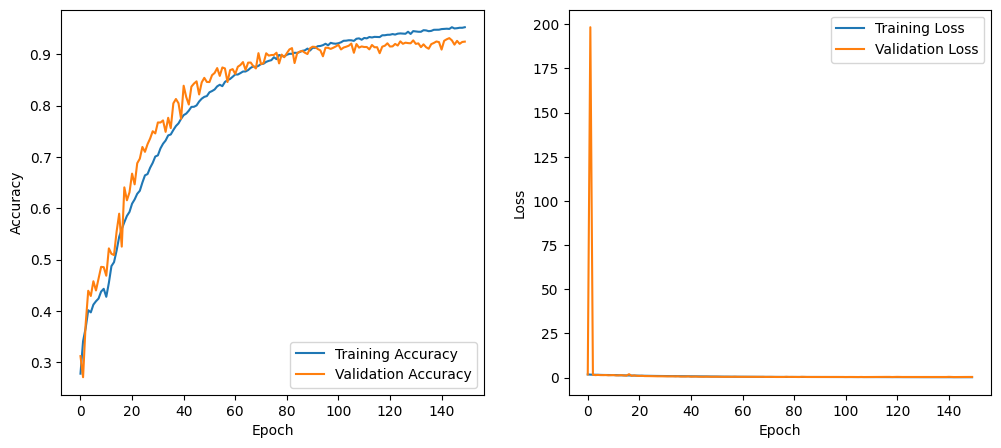

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [25]:
model.save('Final_InceptionV3_model.h5')